In [1]:
from __future__ import with_statement
import sys
import os
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd
import numpy as np
import scipy as sp
import random
import distance
import matplotlib.pyplot as plt
import matplotlib
import itertools
import seaborn as sns
import statsmodels.api as sm 
import warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = 'Helvetica'

from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
from scipy.stats import nbinom

import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from adjustText import adjust_text
import pickle
# R = ro.r

%reload_ext rpy2.ipython
%matplotlib inline

In [3]:
#%R source("https://bioconductor.org/biocLite.R")
#%R biocLite("mpra")
%R library('mpra')

array(['mpra', 'limma', 'SummarizedExperiment', 'DelayedArray',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'stats4', 'BiocGenerics', 'parallel',
       'ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U20')

In [5]:
def log_tf(x):
    return np.log2(x+1)

def reject_outlier(numlist, m=2):
    u = np.mean(numlist)
    s = np.std(numlist)
    filtered = [e for e in numlist if (u - m* s < e < u + m * s)]
    return filtered
    

def orthoregress(x, y):
    """Perform an Orthogonal Distance Regression on the given data,
    using the same interface as the standard scipy.stats.linregress function.
    Arguments:
    x: x data
    y: y data
    Returns:
    [m, c, nan, nan, nan]
    Uses standard ordinary least squares to estimate the starting parameters
    then uses the scipy.odr interface to the ODRPACK Fortran code to do the
    orthogonal distance calculations.
    """
    linreg = linregress(x, y)
    mod = Model(f)
    dat = Data(x, y)
    od = ODR(dat, mod, beta0=linreg[0:2])
    out = od.run()

    return list(out.beta)


def f(p, x):
    """Basic linear regression 'model' for use with ODR"""
    return (p[0] * x) + p[1]

In [6]:
colnames = ['WC1','WC2','WC3','WC4','D1','D2','D3','D4']
for i,s in enumerate(['Syn-R1','Syn-R2','WC1','WC2','Syn-D1','Syn-D2','D1','D2']):
    tmp = pd.read_csv('%s.btw2.local.align.filter.process.bed'%(s),sep=' ', names = ['alignid','count'])
#     tmp = tmp[tmp['qual']=='T']
#     tmp = tmp.groupby('alignid').count()['qual'].reset_index()
#     print(tmp.head())
    tmp.columns = ['alignid', 'count_%s'%(colnames[i])]
    print(s, tmp.shape, len(set(tmp['alignid'])))
    if i==0:
        countBC_merge = tmp
    else:
        countBC_merge = pd.merge(countBC_merge, tmp, how='outer', on='alignid').fillna(0)

countBC_merge['species'] = countBC_merge['alignid'].apply(lambda x: '|'.join(x.split('|')[:-2]))
countBC_merge['virus'] = countBC_merge['species'].apply(lambda x: x.split('|')[1])
countBC_merge['site'] = countBC_merge['species'].apply(lambda x: x.split('|')[3])
countBC_merge['uniqID'] = countBC_merge['species'].apply(lambda x: x.split('|')[0])

count_merge = countBC_merge.groupby('species').sum().reset_index()
count_merge['virus'] = count_merge['species'].apply(lambda x: x.split('|')[1])
count_merge['site'] = count_merge['species'].apply(lambda x: x.split('|')[3])
count_merge['uniqID'] = count_merge['species'].apply(lambda x: x.split('|')[0])

count_merge.head()

Syn-R1 (89980, 2) 89980
Syn-R2 (89699, 2) 89699
WC1 (89638, 2) 89638
WC2 (89403, 2) 89403
Syn-D1 (90173, 2) 90173
Syn-D2 (90187, 2) 90187
D1 (90224, 2) 90224
D2 (90259, 2) 90259


,species,count_WC1,count_WC2,count_WC3,count_WC4,count_D1,count_D2,count_D3,count_D4,virus,site,uniqID
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",429.0,335.0,477.0,313.0,493.0,372.0,341.0,387.0,ROTAVIRUS_A,"1,130",TILE_ID_001-00001
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",209.0,267.0,399.0,125.0,241.0,272.0,245.0,235.0,ROTAVIRUS_A,"66,195",TILE_ID_001-00002
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",281.0,326.0,726.0,313.0,316.0,362.0,287.0,314.0,ROTAVIRUS_A,"131,260",TILE_ID_001-00003
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",569.0,562.0,1078.0,563.0,724.0,595.0,517.0,568.0,ROTAVIRUS_A,"196,325",TILE_ID_001-00004
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",273.0,304.0,487.0,171.0,312.0,266.0,155.0,236.0,ROTAVIRUS_A,"261,390",TILE_ID_001-00005


In [7]:
countBC_dna = countBC_merge.iloc[:,[0,5,6,7,8]].set_index('alignid')
countBC_dna['ctrl1'] = [50]*len(countBC_dna);countBC_dna['ctrl2'] = [50]*len(countBC_dna);
countBC_dna['ctrl3'] = [50]*len(countBC_dna);countBC_dna['ctrl4'] = [50]*len(countBC_dna)
countBC_dna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
countBC_rna = countBC_merge.iloc[:,[0,1,2,3,4]].set_index('alignid')
countBC_rna['ctrl1'] = [50]*len(countBC_rna);countBC_rna['ctrl2'] = [50]*len(countBC_rna);
countBC_rna['ctrl3'] = [50]*len(countBC_rna);countBC_rna['ctrl4'] = [50]*len(countBC_rna);
countBC_rna.columns = ['rep1','rep2','rep3','rep4','c1','c2','c3','c4']
species_list = list(countBC_merge.set_index('alignid')['species'])
countBC_dna = countBC_dna +20
countBC_rna = countBC_rna +20
countBC_dna.head()

,rep1,rep2,rep3,rep4,c1,c2,c3,c4
alignid,,,,,,,,
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ATCGGAA|0",129.0,122.0,134.0,110.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGTACAA|1",220.0,156.0,132.0,148.0,70,70,70,70
"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|TAAGCGA|2",204.0,154.0,135.0,189.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|ACTGGAA|0",87.0,79.0,90.0,56.0,70,70,70,70
"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,195|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001|CGATAGA|2",166.0,207.0,150.0,195.0,70,70,70,70


In [8]:
%Rpush countBC_dna
%Rpush countBC_rna
%Rpush species_list

%R species_list <- unlist(species_list)

array(['TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       'TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,130|PRETILE_ID_001-00001|PREPRETILE_ID_001-00001',
       ...,
       'TILE_ID_140-00710|MOLLUSCUM_CONTAGIOSUM_VIRUS_SUBTYPE_1|NC_001731.1|134700,134571|PRETILE_ID_140-00175|PREPRETILE_ID_140-00129',
       'TILE_ID_142-00083|COWPOX_VIRUS|NC_003663.2|93820,93949|PRETILE_ID_142-00019|PREPRETILE_ID_142-00019',
       'TILE_ID_143-00173|HUMAN_BETAHERPESVIRUS_5_(HHV-5__HCMV)|NC_006273.2|94391,94520|PRETILE_ID_143-00035|PREPRETILE_ID_143-00032'],
      dtype='<U155')

In [9]:
%R mpraset_example <- MPRASet(DNA = countBC_dna, RNA = countBC_rna, eid = species_list, eseq = NULL, barcode = NULL)

R object with classes: ('MPRASet',) mapped to:

  intcpt episomal
1      1     TRUE
2      1     TRUE
3      1     TRUE
4      1     TRUE
5      1    FALSE
6      1    FALSE
7      1    FALSE
8      1    FALSE


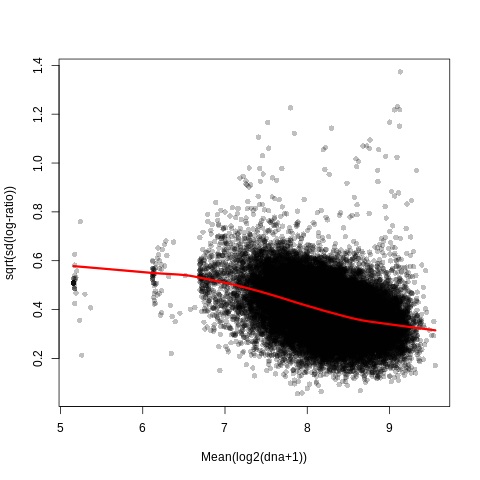

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,TILE_ID_133-00227|ORF_VIRUS|NC_005336.1|117429...,-3.357157,-1.678316,-56.061080,1.824220e-13,4.756811e-09,20.178828
1,TILE_ID_140-00207|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,-2.622552,-1.311624,-51.854336,3.865667e-13,4.756811e-09,19.900599
2,TILE_ID_138-00448|HUMAN_GAMMAHERPESVIRUS_4_(EP...,-3.029370,-1.514022,-50.801147,4.709714e-13,4.756811e-09,19.687450
3,TILE_ID_099-00051|VENEZUELAN_EQUINE_ENCEPHALIT...,-3.020849,-1.509757,-44.785681,1.583096e-12,9.593560e-09,18.799399
4,TILE_ID_129-00003|HUMAN_MASTADENOVIRUS_A|NC_00...,-2.691159,-1.345901,-45.209915,1.445902e-12,9.593560e-09,18.754795


In [10]:
%R data(mpraSetExample)
%R design <- data.frame(intcpt = 1, episomal = grepl("rep", colnames(mpraset_example)))
%R print(design)

%R mpralm_fit <- mpralm(object = mpraset_example, design = design, aggregate = "sum", normalize = TRUE, model_type = "indep_groups", plot = TRUE)

%R toptab <- topTable(mpralm_fit, coef=2, number = Inf)
%R head(toptab)

r.data('toptab')
toptab = r['toptab']
DEsumresult = pandas2ri.rpy2py_dataframe(toptab)
DEsumresult = DEsumresult.reset_index()
DEsumresult.head()

[]

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


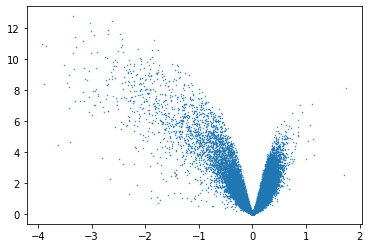

In [11]:
plt.scatter(DEsumresult['logFC'], DEsumresult['P.Value'].apply(lambda x: -np.log10(x)),s=0.2)
plt.plot()

[]

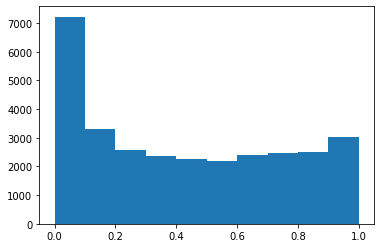

In [12]:
plt.hist(DEsumresult['adj.P.Val'])
plt.plot()

In [13]:
C1 = 'TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|8122,8251|PRETILE_ID_070-00001|PREPRETILE_ID_070-00001|GAGCATA|2'

C1_sp = 'TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|8122,8251|PRETILE_ID_070-00001|PREPRETILE_ID_070-00001'

Fs_list = ['TILE_ID_060-00010','TILE_ID_071-00124','TILE_ID_076-00050','TILE_ID_076-00051','TILE_ID_093-00163','TILE_ID_094-00124','TILE_ID_126-00090','TILE_ID_128-00424','TILE_ID_133-00301','TILE_ID_138-00002','TILE_ID_138-00442','TILE_ID_138-00443','TILE_ID_140-00298','TILE_ID_141-00411','TILE_ID_126-00407']
Fs_stab = [Fs_list[i] for i in [0,4,6,7,8,9,10,14]]

Fs_list = list(set(list(countBC_merge[countBC_merge['uniqID'].isin(Fs_list)]['species'])))
Fs_stab = list(set(list(countBC_merge[countBC_merge['uniqID'].isin(Fs_stab)]['species'])))

DEsumresult[DEsumresult['index'] == C1_sp]

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
780,TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|81...,0.759865,0.380298,8.700716,0.000007,0.000282,3.816801


In [14]:
DEsumresult[DEsumresult['index'].apply(lambda x : x in Fs_stab)].sort_values('index')

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
603,TILE_ID_060-00010|HEPATOVIRUS_A|NC_001489.1|58...,0.635818,0.317648,10.050251,0.000002,0.000103,5.164357
731,TILE_ID_093-00163|SAINT_LOUIS_ENCEPHALITIS_VIR...,0.858587,0.429076,8.965935,0.000005,0.000228,4.159160
3033,TILE_ID_126-00090|HUMAN_CORONAVIRUS_HKU1_(HCOV...,0.522733,0.253350,4.206625,0.001954,0.018739,-1.871572
12442,TILE_ID_126-00407|HUMAN_CORONAVIRUS_HKU1_(HCOV...,0.294215,0.161539,1.526533,0.158940,0.341988,-6.004846
6596,TILE_ID_128-00424|HUMAN_CORONAVIRUS_OC43_(HCOV...,0.520643,0.292754,2.862301,0.017465,0.081690,-4.263287
937,TILE_ID_133-00301|ORF_VIRUS|NC_005336.1|134347...,1.138121,0.577274,7.960235,0.000015,0.000499,3.036669
27991,TILE_ID_138-00002|HUMAN_GAMMAHERPESVIRUS_4_(EP...,0.102817,0.059610,0.568304,0.582801,0.749210,-7.518126
1857,TILE_ID_138-00442|HUMAN_GAMMAHERPESVIRUS_4_(EP...,1.005687,0.510897,5.562551,0.000272,0.004607,-0.091341


In [193]:
sp = 'TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001653.2|651,780|PRETILE_ID_016-00001|PREPRETILE_ID_016-00001'
countBC_merge[countBC_merge['species']==sp]

,alignid,count_WC1,count_WC2,count_WC3,count_WC4,count_D1,count_D2,count_D3,count_D4,species,virus,site,uniqID,ratio_WC1,ratio_WC2,ratio_WC3,ratio_WC4,sum_RNA,sum_DNA,readsum
10489,TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001...,11.826217,33.308620,13.440478,16.707058,415.753027,464.511780,386.417257,434.420258,TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001...,HEPATITIS_DELTA_VIRUS,"651,780",TILE_ID_016-00011,0.073037,0.110025,0.082281,0.080778,75.282373,1701.102323,1776.384696
10490,TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001...,18.276881,18.736099,33.247498,13.126974,528.782810,610.409245,528.723896,370.061701,TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001...,HEPATITIS_DELTA_VIRUS,"651,780",TILE_ID_016-00011,0.069749,0.061446,0.097039,0.084928,83.387452,2037.977652,2121.365104
10491,TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001...,9.675996,23.940570,19.099627,64.441511,386.266997,403.363578,352.482597,323.803989,TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001...,HEPATITIS_DELTA_VIRUS,"651,780",TILE_ID_016-00011,0.073046,0.103789,0.104970,0.245609,117.157703,1465.917161,1583.074864


In [15]:
sp = 'TILE_ID_142-00323|COWPOX_VIRUS|NC_003663.2|180751,180880|PRETILE_ID_142-00069|PREPRETILE_ID_142-00069'

countBC_merge[countBC_merge['species']==sp]

,alignid,count_WC1,count_WC2,count_WC3,count_WC4,count_D1,count_D2,count_D3,count_D4,species,virus,site,uniqID
84481,TILE_ID_142-00323|COWPOX_VIRUS|NC_003663.2|180...,15.0,5.0,0.0,3.0,2.0,0.0,0.0,0.0,TILE_ID_142-00323|COWPOX_VIRUS|NC_003663.2|180...,COWPOX_VIRUS,"180751,180880",TILE_ID_142-00323


In [16]:
tmp = DEsumresult[DEsumresult['logFC']<-1][DEsumresult['adj.P.Val']<0.001].sort_values('logFC',ascending = False)
print(tmp.shape)
negstat_list1 = list(tmp['index'])
tmp

(628, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
1026,TILE_ID_078-00107|HUMAN_T-LYMPHOTROPIC_VIRUS_2...,-1.000092,-0.479445,-7.468844,2.595593e-05,7.569438e-04,2.571143
553,TILE_ID_034-00006|ARGENTINIAN_MAMMARENAVIRUS|N...,-1.001799,-0.494666,-10.303208,1.600968e-06,8.570553e-05,5.603210
573,"TILE_ID_133-00038|ORF_VIRUS|NC_005336.1|43016,...",-1.002174,-0.501211,-10.259879,1.662274e-06,8.805401e-05,5.408197
280,TILE_ID_076-00104|BORNA_DISEASE_VIRUS_1_(BODV-...,-1.004712,-0.502842,-14.095007,9.250010e-08,9.816570e-06,8.528737
794,TILE_ID_140-00732|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,-1.004850,-0.357435,-8.526123,8.434815e-06,3.239225e-04,3.714710
...,...,...,...,...,...,...,...
125,TILE_ID_070-00104|AICHI_VIRUS_1|NC_001918.1|66...,-3.453782,-1.726891,-19.849903,3.756901e-09,8.963315e-07,11.765217
43,"TILE_ID_133-00343|ORF_VIRUS|NC_005336.1|7275,7...",-3.523601,-1.760577,-26.402844,2.503057e-10,1.722158e-07,14.453389
13,TILE_ID_138-00224|HUMAN_GAMMAHERPESVIRUS_4_(EP...,-3.847771,-1.924007,-35.264437,1.571398e-11,3.076156e-08,16.982274
127,TILE_ID_137-00484|HUMAN_BETAHERPESVIRUS_6B_(HH...,-3.890379,-1.940624,-19.728622,3.980769e-09,9.350179e-07,11.718661


In [17]:
ID = 'TILE_ID_138-00443'

countBC_merge[countBC_merge.species.apply(lambda x: x.split('|')[0]==ID)]

,alignid,count_WC1,count_WC2,count_WC3,count_WC4,count_D1,count_D2,count_D3,count_D4,species,virus,site,uniqID
75790,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,821.0,921.0,1225.0,951.0,287.0,223.0,227.0,265.0,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,HUMAN_GAMMAHERPESVIRUS_4_(EPSTEIN-BARR_VIRUS),"88961,88832",TILE_ID_138-00443
75791,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,945.0,1146.0,1390.0,905.0,388.0,301.0,254.0,287.0,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,HUMAN_GAMMAHERPESVIRUS_4_(EPSTEIN-BARR_VIRUS),"88961,88832",TILE_ID_138-00443
75792,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,1033.0,961.0,1169.0,866.0,322.0,289.0,233.0,189.0,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,HUMAN_GAMMAHERPESVIRUS_4_(EPSTEIN-BARR_VIRUS),"88961,88832",TILE_ID_138-00443


In [18]:
tmp = DEsumresult[DEsumresult['logFC']>0.5][DEsumresult['adj.P.Val']<0.01].sort_values('logFC',ascending = False)
print(tmp.shape)
stat_list1 = list(tmp['index'])
tmp

(164, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
151,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,1.756493,0.883984,18.325806,7.978935e-09,0.000002,11.014349
1574,TILE_ID_143-00201|HUMAN_BETAHERPESVIRUS_5_(HHV...,1.151580,0.579073,6.009728,1.504093e-04,0.002948,0.583307
937,TILE_ID_133-00301|ORF_VIRUS|NC_005336.1|134347...,1.138121,0.577274,7.960235,1.517838e-05,0.000499,3.036669
278,TILE_ID_140-00299|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,1.106502,0.553404,14.251328,8.352691e-08,0.000009,8.543595
578,TILE_ID_076-00050|BORNA_DISEASE_VIRUS_1_(BODV-...,1.074158,0.529160,10.173409,1.792453e-06,0.000094,5.395986
...,...,...,...,...,...,...,...
738,TILE_ID_092-00105|YELLOW_FEVER_VIRUS_(YFV)|NC_...,0.502874,0.253173,8.877175,5.948287e-06,0.000244,4.108870
1759,TILE_ID_126-00143|HUMAN_CORONAVIRUS_HKU1_(HCOV...,0.502666,0.251865,5.382272,3.484265e-04,0.005542,0.141898
1626,TILE_ID_128-00362|HUMAN_CORONAVIRUS_OC43_(HCOV...,0.502649,0.249376,5.821247,1.924854e-04,0.003563,0.456226
1396,TILE_ID_126-00296|HUMAN_CORONAVIRUS_HKU1_(HCOV...,0.502513,0.249379,6.066933,1.396924e-04,0.002788,1.093487


In [143]:
tmp = DEsumresult[DEsumresult['logFC']>0.5][DEsumresult['adj.P.Val']<0.05].sort_values('logFC',ascending = False)
print(tmp.shape)
stat_list3 = list(tmp['index'])
tmp

(245, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
151,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,1.756493,0.883984,18.325806,7.978935e-09,0.000002,11.014349
3754,TILE_ID_066-00004|ENCEPHALOMYOCARDITIS_VIRUS|N...,1.717851,0.623522,3.946405,2.938885e-03,0.024805,-2.549328
1574,TILE_ID_143-00201|HUMAN_BETAHERPESVIRUS_5_(HHV...,1.151580,0.579073,6.009728,1.504093e-04,0.002948,0.583307
937,TILE_ID_133-00301|ORF_VIRUS|NC_005336.1|134347...,1.138121,0.577274,7.960235,1.517838e-05,0.000499,3.036669
278,TILE_ID_140-00299|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,1.106502,0.553404,14.251328,8.352691e-08,0.000009,8.543595
...,...,...,...,...,...,...,...
4127,TILE_ID_011-00030|INFLUENZA_B_VIRUS_(B_LEE_194...,0.502283,0.249694,3.451767,6.533890e-03,0.042686,-2.846629
3312,TILE_ID_128-00146|HUMAN_CORONAVIRUS_OC43_(HCOV...,0.502183,0.263046,4.119705,2.237383e-03,0.020663,-2.153696
1650,TILE_ID_123-00425|BREDA_VIRUS|NC_007447.1|2759...,0.501073,0.250688,5.782596,2.025926e-04,0.003707,0.405730
3084,TILE_ID_131-00139|HUMAN_ALPHAHERPESVIRUS_3_(HH...,0.500340,0.261978,4.222155,1.907858e-03,0.018404,-1.937258


  intcpt episomal
1      1     TRUE
2      1     TRUE
3      1     TRUE
4      1     TRUE
5      1    FALSE
6      1    FALSE
7      1    FALSE
8      1    FALSE


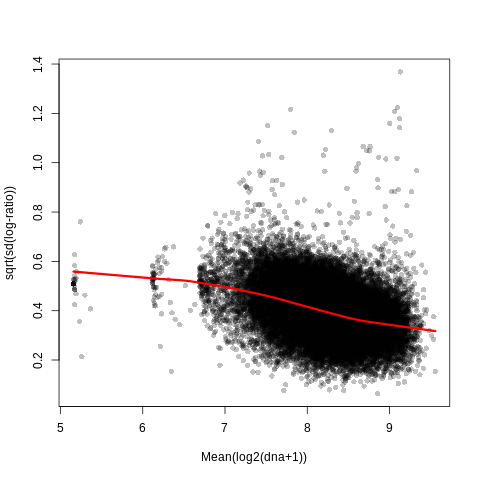

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,TILE_ID_133-00227|ORF_VIRUS|NC_005336.1|117429...,-3.304896,-1.652210,-52.285164,2.719029e-13,8.238657e-09,19.965603
1,TILE_ID_140-00172|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,-2.607240,-1.302528,-45.148028,1.134734e-12,8.468963e-09,19.212814
2,TILE_ID_143-00404|HUMAN_BETAHERPESVIRUS_5_(HHV...,-2.490047,-1.245024,-44.952530,1.183666e-12,8.468963e-09,19.201723
3,TILE_ID_099-00051|VENEZUELAN_EQUINE_ENCEPHALIT...,-2.990621,-1.494737,-44.507473,1.303966e-12,8.468963e-09,18.964040
4,TILE_ID_140-00207|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,-2.683057,-1.341801,-43.664422,1.570544e-12,8.468963e-09,18.888758


In [19]:
%R data(mpraSetExample)
%R design <- data.frame(intcpt = 1, episomal = grepl("rep", colnames(mpraset_example)))
%R print(design)

%R mpralm_fit <- mpralm(object = mpraset_example, design = design, aggregate = "mean", normalize = TRUE, model_type = "indep_groups", plot = TRUE)

%R toptab <- topTable(mpralm_fit, coef=2, number = Inf)
%R head(toptab)

r.data('toptab')
toptab = r['toptab']
DEresultmean = pandas2ri.rpy2py_dataframe(toptab)
DEresultmean = DEresultmean.reset_index()
DEresultmean.head()

In [20]:
DEresultmean[DEresultmean['index'] == C1_sp]

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
845,TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|81...,0.752846,0.376561,9.437089,0.000003,0.000117,4.662721


In [21]:
tmp = DEresultmean[DEresultmean['logFC']<-1][DEresultmean['adj.P.Val']<0.001].sort_values('logFC',ascending = False)
print(tmp.shape)
negstat_list2 = list(tmp['index'])
tmp

(812, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
540,TILE_ID_136-00239|HUMAN_ALPHAHERPESVIRUS_2_(HE...,-1.001404,-0.497572,-11.454604,5.561368e-07,3.025305e-05,6.707394
243,"TILE_ID_063-00009|COSAVIRUS_A|NC_012800.1|521,...",-1.001892,-0.500310,-16.298320,2.079275e-08,2.581353e-06,10.029275
1123,TILE_ID_131-00131|HUMAN_ALPHAHERPESVIRUS_3_(HH...,-1.002416,-0.499749,-8.184726,1.113090e-05,3.032970e-04,3.377411
255,TILE_ID_102-00165|BARMAH_FOREST_VIRUS|NC_00178...,-1.002549,-0.502400,-15.952236,2.546684e-08,3.037973e-06,9.806862
177,TILE_ID_143-00188|HUMAN_BETAHERPESVIRUS_5_(HHV...,-1.005084,-0.502561,-18.417805,6.517724e-09,1.103280e-06,11.189450
...,...,...,...,...,...,...,...
46,"TILE_ID_133-00343|ORF_VIRUS|NC_005336.1|7275,7...",-3.472679,-1.734661,-27.116873,1.592092e-10,9.844976e-08,14.878747
194,TILE_ID_070-00104|AICHI_VIRUS_1|NC_001918.1|66...,-3.485089,-1.742545,-18.008929,8.069988e-09,1.263489e-06,10.969491
117,TILE_ID_137-00484|HUMAN_BETAHERPESVIRUS_6B_(HH...,-3.792897,-1.892280,-20.942078,1.911513e-09,4.908376e-07,12.444730
17,TILE_ID_138-00224|HUMAN_GAMMAHERPESVIRUS_4_(EP...,-3.793831,-1.896608,-34.430635,1.578685e-11,2.619019e-08,16.980328


In [22]:
tmp = DEresultmean[DEresultmean['logFC']>0.5][DEresultmean['adj.P.Val']<0.01].sort_values('logFC',ascending = False)
print(tmp.shape)
stat_list2 = list(tmp['index'])
tmp

(128, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
199,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,1.757621,0.884590,17.873563,8.670183e-09,0.000001,10.918686
1903,TILE_ID_143-00201|HUMAN_BETAHERPESVIRUS_5_(HHV...,1.146413,0.576581,5.870603,1.721679e-04,0.002781,0.438846
1071,TILE_ID_133-00301|ORF_VIRUS|NC_005336.1|134347...,1.124440,0.569784,8.397900,8.909730e-06,0.000256,3.602990
1125,TILE_ID_076-00050|BORNA_DISEASE_VIRUS_1_(BODV-...,1.061460,0.519844,8.123637,1.187378e-05,0.000318,3.374312
1048,TILE_ID_075-00103|HUSAVIRUS_SP.|NC_032480.1|66...,1.059804,0.546420,8.349795,9.365067e-06,0.000267,3.722736
...,...,...,...,...,...,...,...
1981,TILE_ID_126-00030|HUMAN_CORONAVIRUS_HKU1_(HCOV...,0.504481,0.254288,5.503160,2.829719e-04,0.004130,0.254728
1461,TILE_ID_123-00394|BREDA_VIRUS|NC_007447.1|2558...,0.503346,0.253889,6.773403,5.482410e-05,0.001104,1.901643
1827,TILE_ID_112-00022|HUMAN_RESPIROVIRUS_3|NC_0017...,0.502197,0.252405,5.791911,1.911987e-04,0.003025,0.654861
2074,TILE_ID_034-00005|ARGENTINIAN_MAMMARENAVIRUS|N...,0.501847,0.255522,5.510545,2.801080e-04,0.004096,0.009958


In [23]:
stat_list = list(set(stat_list1).intersection(set(stat_list2)))
print(len(stat_list))

difflist = list(set(stat_list1).difference(set(stat_list2)))

119


In [29]:
tmp = (count_merge.iloc[:,1:9]/count_merge.iloc[:,1:9].sum())*np.mean(count_merge.iloc[:,1:9].sum())
count_merge = pd.concat([count_merge.iloc[:,0], tmp,count_merge.iloc[:,9:]], axis=1)

tmp = (countBC_merge.iloc[:,1:9]/countBC_merge.iloc[:,1:9].sum())*np.mean(countBC_merge.iloc[:,1:9].sum())
countBC_merge = pd.concat([countBC_merge.iloc[:,0], tmp,countBC_merge.iloc[:,9:]], axis=1)

count_merge.sum()

species      TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...
count_WC1                                          1.82643e+07
count_WC2                                          1.82643e+07
count_WC3                                          1.82643e+07
count_WC4                                          1.82643e+07
count_D1                                           1.82643e+07
count_D2                                           1.82643e+07
count_D3                                           1.82643e+07
count_D4                                           1.82643e+07
virus        ROTAVIRUS_AROTAVIRUS_AROTAVIRUS_AROTAVIRUS_ARO...
site         1,13066,195131,260196,325261,390326,455391,520...
uniqID       TILE_ID_001-00001TILE_ID_001-00002TILE_ID_001-...
dtype: object

In [30]:
psu = 50

count_merge['ratio_WC1'] = (count_merge['count_WC1']+psu)/(count_merge['count_D1']+psu)
count_merge['ratio_WC2'] = (count_merge['count_WC2']+psu)/(count_merge['count_D2']+psu)
count_merge['ratio_WC3'] = (count_merge['count_WC3']+psu)/(count_merge['count_D3']+psu)
count_merge['ratio_WC4'] = (count_merge['count_WC4']+psu)/(count_merge['count_D4']+psu)

count_merge['sum_RNA'] = count_merge['count_WC1'] + count_merge['count_WC2'] + count_merge['count_WC3']  + count_merge['count_WC4'] 
count_merge['sum_DNA'] = count_merge['count_D1'] + count_merge['count_D2'] + count_merge['count_D3']+count_merge['count_D4']


count_merge['readsum'] = count_merge.iloc[:,1:9].sum(axis=1)

count_merge.head()

,species,count_WC1,count_WC2,count_WC3,count_WC4,count_D1,count_D2,count_D3,count_D4,virus,site,uniqID,ratio_WC1,ratio_WC2,ratio_WC3,ratio_WC4,sum_RNA,sum_DNA,readsum
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",461.222456,348.699612,337.426739,373.522090,484.553764,399.072476,373.281260,389.168148,ROTAVIRUS_A,"1,130",TILE_ID_001-00001,0.956354,0.887829,0.915294,0.964373,1520.870897,1646.075648,3166.946546
1,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",224.698120,277.918795,282.250040,149.170164,236.871110,291.794929,268.193281,236.316576,ROTAVIRUS_A,"66,195",TILE_ID_001-00002,0.957566,0.959402,1.044177,0.695629,934.037119,1033.175895,1967.213014
2,"TILE_ID_001-00003|ROTAVIRUS_A|NC_011505.2|131,...",302.106084,339.331563,513.567742,373.522090,310.586186,388.344722,314.169271,315.759169,ROTAVIRUS_A,"131,260",TILE_ID_001-00003,0.976482,0.888186,1.547543,1.157926,1528.527479,1328.859348,2857.386826
3,"TILE_ID_001-00004|ROTAVIRUS_A|NC_011505.2|196,...",611.737943,584.982633,762.570283,671.862417,711.596198,638.301407,565.942555,571.182191,ROTAVIRUS_A,"196,325",TILE_ID_001-00004,0.868883,0.922536,1.319231,1.162078,2631.153276,2487.022351,5118.175627
4,"TILE_ID_001-00005|ROTAVIRUS_A|NC_011505.2|261,...",293.505199,316.431887,344.500675,204.064784,306.654715,285.358276,169.673300,237.322178,ROTAVIRUS_A,"261,390",TILE_ID_001-00005,0.963131,1.092658,1.795852,0.884251,1158.502545,999.008469,2157.511014


In [31]:
psu = 20

countBC_merge['ratio_WC1'] = (countBC_merge['count_WC1']+psu)/(countBC_merge['count_D1']+psu)
countBC_merge['ratio_WC2'] = (countBC_merge['count_WC2']+psu)/(countBC_merge['count_D2']+psu)
countBC_merge['ratio_WC3'] = (countBC_merge['count_WC3']+psu)/(countBC_merge['count_D3']+psu)
countBC_merge['ratio_WC4'] = (countBC_merge['count_WC4']+psu)/(countBC_merge['count_D4']+psu)

countBC_merge['sum_RNA'] = countBC_merge['count_WC1'] + countBC_merge['count_WC2'] + countBC_merge['count_WC3']+ countBC_merge['count_WC4'] 
countBC_merge['sum_DNA'] = countBC_merge['count_D1'] + countBC_merge['count_D2'] + countBC_merge['count_D3']+ countBC_merge['count_D4'] 

countBC_merge['readsum'] = countBC_merge.iloc[:,1:9].sum(axis=1)

countBC_merge.head()

,alignid,count_WC1,count_WC2,count_WC3,count_WC4,count_D1,count_D2,count_D3,count_D4,species,virus,site,uniqID,ratio_WC1,ratio_WC2,ratio_WC3,ratio_WC4,sum_RNA,sum_DNA,readsum
0,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",103.210620,85.353338,49.517551,31.027394,107.132577,109.423098,124.791975,90.504220,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",ROTAVIRUS_A,"1,130",TILE_ID_001-00001,0.969151,0.814023,0.480120,0.461769,269.108902,431.851871,700.960773
1,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",184.919027,132.193584,195.240629,140.816634,196.573535,145.897464,122.602643,128.717114,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",ROTAVIRUS_A,"1,130",TILE_ID_001-00001,0.946187,0.917395,1.509373,1.081359,653.169875,593.790756,1246.960630
2,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",173.092810,131.152690,92.668559,201.678061,180.847652,143.751914,125.886642,169.946814,"TILE_ID_001-00001|ROTAVIRUS_A|NC_011505.2|1,13...",ROTAVIRUS_A,"1,130",TILE_ID_001-00001,0.961389,0.923059,0.772302,1.167053,598.592120,620.433022,1219.025142
3,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",64.506637,69.739922,72.154146,35.800839,65.852134,63.293753,76.626652,36.201688,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",ROTAVIRUS_A,"66,195",TILE_ID_001-00002,0.984328,1.077391,0.953714,0.992868,242.201544,241.974227,484.175771
4,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",140.839491,197.769929,155.626588,78.761846,143.498681,200.609014,142.306639,175.980429,"TILE_ID_001-00002|ROTAVIRUS_A|NC_011505.2|66,1...",ROTAVIRUS_A,"66,195",TILE_ID_001-00002,0.983736,0.987131,1.082067,0.503937,572.997855,662.394762,1235.392617


In [34]:
C1 = 'TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|8122,8251|PRETILE_ID_070-00001|PREPRETILE_ID_070-00001|GAGCATA|2'

C1_sp = 'TILE_ID_070-00126|AICHI_VIRUS_1|NC_001918.1|8122,8251|PRETILE_ID_070-00001|PREPRETILE_ID_070-00001'


In [61]:
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

savedir = '/casa/jenny/notebooks/pan-viral_MPRA/paper_figures/'

In [203]:
df_tax = pd.read_excel('/casa/jenny/notebooks/pan-viral_MPRA/Data/human_virus_dbtable_selected_220605update.xlsx').fillna(method='ffill')
df_tax.columns = [list(df_tax.columns)[0]]+['FAMILY','GENUS','Name','Segment','ID']

df_tax.loc[24,'Genome Type'] ='SS-DNA'
df_tax.loc[25,'Genome Type'] ='SS-DNA'

print(len(set(df_tax['FAMILY'])))
print(len(set(df_tax['GENUS'])))
print(len(set(df_tax['Name'])))
df_tax.head()

38
98
144


,Genome Type,FAMILY,GENUS,Name,Segment,ID
0,DS-DNA,ADENOVIRIDAE,MASTADENOVIRUS,HUMAN MASTADENOVIRUS A,GENOME,NC_001460.1
1,DS-DNA,HERPESVIRIDAE,CYTOMEGALOVIRUS,HUMAN BETAHERPESVIRUS 5 (HHV-5; HCMV),GENOME,NC_006273.2
2,DS-DNA,HERPESVIRIDAE,LYMPHOCRYPTOVIRUS,HUMAN GAMMAHERPESVIRUS 4 (EPSTEIN-BARR VIRUS),GENOME,NC_007605.1
3,DS-DNA,HERPESVIRIDAE,RHADINOVIRUS,HUMAN GAMMAHERPESVIRUS 8 (KAPOSI'S SARCOMA-ASS...,GENOME,NC_009333.1
4,DS-DNA,HERPESVIRIDAE,ROSEOLOVIRUS,HUMAN BETAHERPESVIRUS 6B (HHV-6B),GENOME,NC_000898.1


In [192]:
[print('%s.'%(i+1),'\t'.join(x.split('|')[1:4])) for i,x in enumerate(DEsumresult.sort_values('logFC',ascending = False).head(n=25)['index'])]

DEsumresult.sort_values('logFC',ascending = False).head(n=20)

1. HUMAN_GAMMAHERPESVIRUS_4_(EPSTEIN-BARR_VIRUS)	NC_007605.1	88961,88832
2. ENCEPHALOMYOCARDITIS_VIRUS	NC_001479.1	196,325
3. HUMAN_BETAHERPESVIRUS_5_(HHV-5__HCMV)	NC_006273.2	96273,96402
4. ORF_VIRUS	NC_005336.1	134347,134476
5. MOLLUSCUM_CONTAGIOSUM_VIRUS_SUBTYPE_1	NC_001731.1	164859,164988
6. BORNA_DISEASE_VIRUS_1_(BODV-1)	NC_001607.1	3368,3497
7. HUSAVIRUS_SP.	NC_032480.1	6695,6824
8. HUMAN_GAMMAHERPESVIRUS_4_(EPSTEIN-BARR_VIRUS)	NC_007605.1	89026,88897
9. POSITIVE_CONTROL(SL27)	GU937742.2	110,240
10. POSITIVE_CONTROL(SL27)	GU937742.2	100,230
11. SAINT_LOUIS_ENCEPHALITIS_VIRUS	NC_007580.2	10613,10742
12. BREDA_VIRUS	NC_007447.1	7510,7639
13. POSITIVE_CONTROL(SL27)	GU937742.2	90,220
14. HUMAN_CORONAVIRUS_OC43_(HCOV-OC43)	NC_006213.1	7281,7410
15. SIN_NOMBRE_ORTHOHANTAVIRUS	NC_005216.1	1561,1690
16. MOLLUSCUM_CONTAGIOSUM_VIRUS_SUBTYPE_1	NC_001731.1	164794,164923
17. HUMAN_BETAHERPESVIRUS_5_(HHV-5__HCMV)	NC_006273.2	4579,4450
18. HUMAN_CORONAVIRUS_HKU1_(HCOV-HKU1)	NC_006577.2	15809,15

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
151,TILE_ID_138-00443|HUMAN_GAMMAHERPESVIRUS_4_(EP...,1.756493,0.883984,18.325806,7.978935e-09,0.000002,11.014349
3754,TILE_ID_066-00004|ENCEPHALOMYOCARDITIS_VIRUS|N...,1.717851,0.623522,3.946405,2.938885e-03,0.024805,-2.549328
1574,TILE_ID_143-00201|HUMAN_BETAHERPESVIRUS_5_(HHV...,1.151580,0.579073,6.009728,1.504093e-04,0.002948,0.583307
937,TILE_ID_133-00301|ORF_VIRUS|NC_005336.1|134347...,1.138121,0.577274,7.960235,1.517838e-05,0.000499,3.036669
278,TILE_ID_140-00299|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,1.106502,0.553404,14.251328,8.352691e-08,0.000009,8.543595
578,TILE_ID_076-00050|BORNA_DISEASE_VIRUS_1_(BODV-...,1.074158,0.529160,10.173409,1.792453e-06,0.000094,5.395986
956,TILE_ID_075-00103|HUSAVIRUS_SP.|NC_032480.1|66...,1.033120,0.537070,7.692549,2.026666e-05,0.000629,2.917038
1857,TILE_ID_138-00442|HUMAN_GAMMAHERPESVIRUS_4_(EP...,1.005687,0.510897,5.562551,2.721834e-04,0.004607,-0.091341
367,TILE_ID_144-00012|POSITIVE_CONTROL(SL27)|GU937...,0.932679,0.466838,12.566222,2.659626e-07,0.000022,7.343840
293,TILE_ID_144-00011|POSITIVE_CONTROL(SL27)|GU937...,0.893998,0.446972,13.989733,9.913812e-08,0.000010,8.380789


In [239]:
[print('%s.'%(i+1),' '.join(x.split('|')[1:4])) for i,x in enumerate(DEsumresult.sort_values('logFC',ascending = False).tail(n=25)['index'])]

[print('%s.'%(i+1),' '.join(x.split('|')[1:4])) for i,x in enumerate(DEsumresult.sort_values('logFC',ascending = True).head(n=25)['index'])]

DEsumresult.sort_values('logFC',ascending = False).tail(n=25)


1. PEGIVIRUS_A NC_001837.1 3706,3835
2. MOLLUSCUM_CONTAGIOSUM_VIRUS_SUBTYPE_1 NC_001731.1 99789,99660
3. HUMAN_BETAHERPESVIRUS_5_(HHV-5__HCMV) NC_006273.2 29277,29148
4. GREAT_ISLAND_VIRUS_(GIV) NC_014524.1 1303,1432
5. MOLLUSCUM_CONTAGIOSUM_VIRUS_SUBTYPE_1 NC_001731.1 140576,140447
6. ORF_VIRUS NC_005336.1 132605,132734
7. HUMAN_BETAHERPESVIRUS_5_(HHV-5__HCMV) NC_006273.2 168911,168782
8. HUMAN_GAMMAHERPESVIRUS_4_(EPSTEIN-BARR_VIRUS) NC_007605.1 134293,134422
9. HUMAN_GAMMAHERPESVIRUS_8_(KAPOSI'S_SARCOMA-ASSOCIATED_HERPESVIRUS) NC_009333.1 38265,38394
10. HUMAN_GAMMAHERPESVIRUS_4_(EPSTEIN-BARR_VIRUS) NC_007605.1 923,1052
11. HUMAN_ALPHAHERPESVIRUS_1_(HERPES_SIMPLEX_VIRUS_1) NC_001806.2 124112,124241
12. HEPATITIS_GB_VIRUS_B NC_001655.1 1301,1430
13. SEVERE_FEVER_WITH_THROMBOCYTOPENIA_SYNDROME_VIRUS NC_043452.1 511,382
14. HUMAN_GAMMAHERPESVIRUS_4_(EPSTEIN-BARR_VIRUS) NC_007605.1 273,402
15. ORF_VIRUS NC_005336.1 117429,117558
16. HUMAN_ALPHAHERPESVIRUS_2_(HERPES_SIMPLEX_VIRUS_2) NC_00

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
63,TILE_ID_083-00058|PEGIVIRUS_A|NC_001837.1|3706...,-3.054827,-1.526767,-24.126107,5.908739e-10,2.797418e-07,13.620172
209,TILE_ID_140-00634|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,-3.056960,-1.528480,-16.046552,2.771554e-08,4.056913e-06,9.700620
109,TILE_ID_143-00502|HUMAN_BETAHERPESVIRUS_5_(HHV...,-3.085224,-1.541596,-20.865996,2.343292e-09,6.454705e-07,12.247781
99,TILE_ID_002-00152|GREAT_ISLAND_VIRUS_(GIV)|NC_...,-3.126199,-1.562218,-21.343474,1.891386e-09,5.704590e-07,12.463323
246,TILE_ID_140-00737|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,-3.142743,-1.573506,-15.056696,5.016051e-08,6.229734e-06,9.098857
52,TILE_ID_133-00295|ORF_VIRUS|NC_005336.1|132605...,-3.143780,-1.569812,-25.103955,4.048172e-10,2.271474e-07,13.990532
11,TILE_ID_143-00830|HUMAN_BETAHERPESVIRUS_5_(HHV...,-3.158845,-1.574288,-38.264493,7.179454e-12,1.812812e-08,17.408128
175,TILE_ID_138-00359|HUMAN_GAMMAHERPESVIRUS_4_(EP...,-3.164575,-1.584948,-17.304782,1.367318e-08,2.353963e-06,10.457383
251,TILE_ID_132-00246|HUMAN_GAMMAHERPESVIRUS_8_(KA...,-3.208068,-1.588073,-14.898310,5.533988e-08,6.658244e-06,9.052973
16,TILE_ID_138-00011|HUMAN_GAMMAHERPESVIRUS_4_(EP...,-3.286684,-1.638995,-34.921200,1.725896e-11,3.076156e-08,16.740092


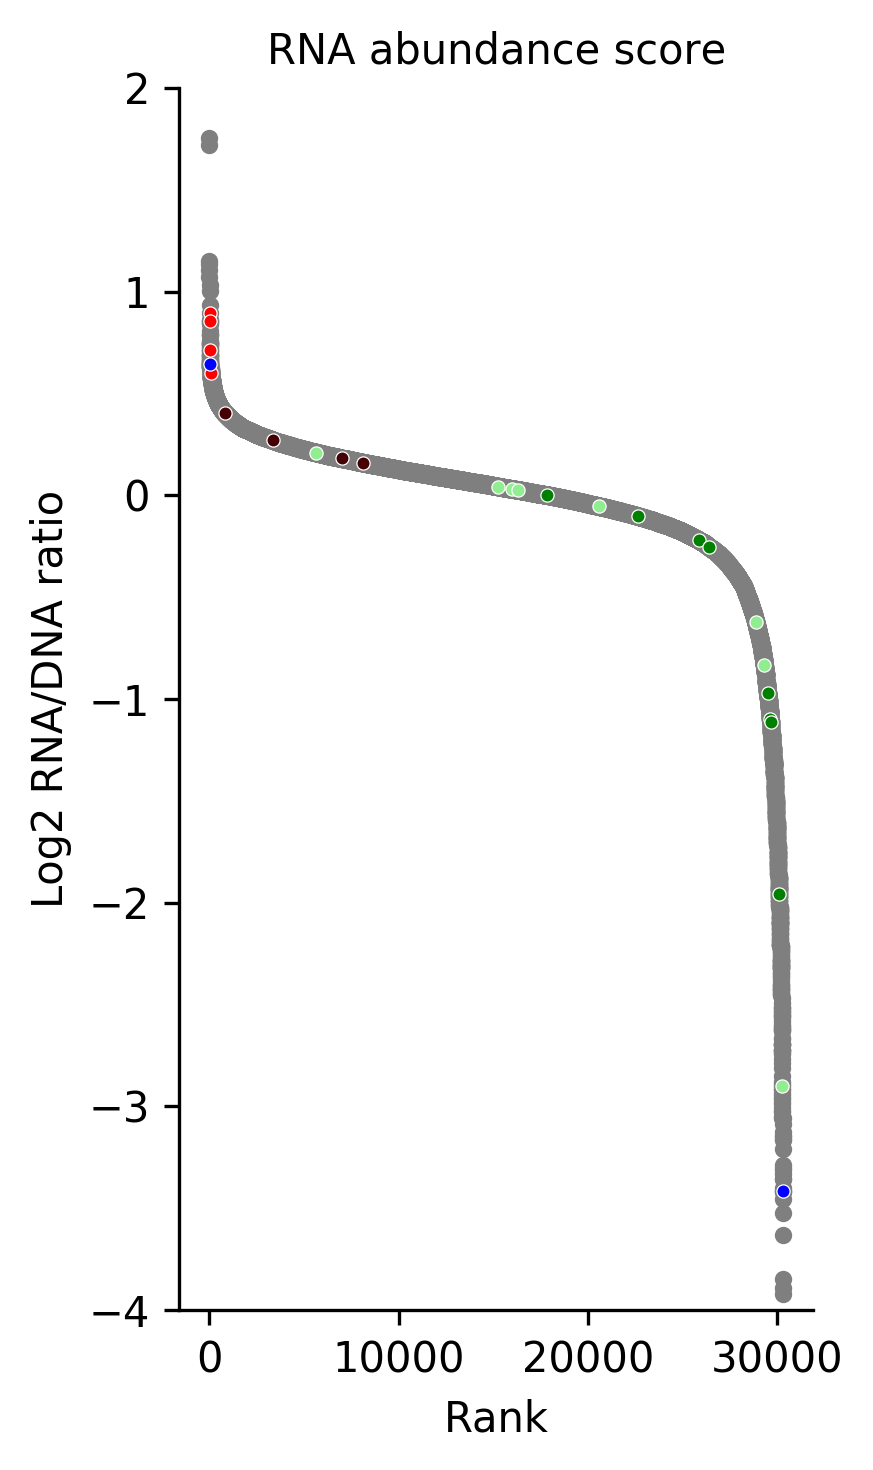

In [285]:
tmp_df = DEsumresult.sort_values('logFC',ascending = False).reset_index(drop=True)
HDV = 'TILE_ID_016-00011|HEPATITIS_DELTA_VIRUS|NC_001653.2|651,780|PRETILE_ID_016-00001|PREPRETILE_ID_016-00001'
WPRE = 'TILE_ID_032-00022|WOODCHUCK_HEPATITIS_VIRUS|NC_004107.1|1366,1495|PRETILE_ID_032-00001|PREPRETILE_ID_032-00001'

with open('/casa/jenny/notebooks/pan-viral_MPRA/Data/220828_miRNAdf_filterall_10dist.pickle', 'rb') as f:
    miRNA_df = pickle.load(f)
miRNA = list(set(miRNA_df['seq_id'].apply(lambda x: x[:-10])))

miRNA_ebv = [x for x in miRNA if 'EPSTEIN-BARR_VIRUS' in x]
miRNA_cmv = [x for x in miRNA if '5__HCMV' in x]

tmp_pos = tmp_df[tmp_df['index'].isin(SL27_pos_sp['species'])]
tmp_neg = tmp_df[tmp_df['index'].isin(SL27_neg_sp['species'])]

plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none'

pos = list(range(len(tmp_df))) 
width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(3,5),dpi = 300)

# Create a bar with pre_score data,
# in position pos,
plt.scatter([width*p for p in pos],
         [p for p in tmp_df['logFC']],
        #alpha=0.5, 
        color= '#7F7F7F', #colors,    #'#EE3224', 
        marker = 'o',s = 10,
#         edgecolor = 'white',linewidth= 0.05,
        zorder = 3,rasterized = True) 

# plt.scatter([width*p for p in pos],
#          [p for p in tmp_df['logFC']][:20],
#         #alpha=0.5, 
#         color= '#7F7F7F', #colors,    #'#EE3224', 
#         marker = 'o',s = 10,
#         edgecolor = 'white',linewidth= 0.1,
#         zorder = 3) 

# plt.scatter([width*p for p in pos][-20:],
#          [p for p in tmp_df['logFC']][-20:],
#         #alpha=0.5, 
#         color= '#7F7F7F', #colors,    #'#EE3224', 
#         marker = 'o',s = 10,
#         edgecolor = 'white',linewidth= 0.1,
#         zorder = 3)

plt.scatter([width*p for p in tmp_pos.index],
         [p for p in tmp_pos['logFC']],
        #alpha=0.5, 
        color= 'red', #colors,    #'#EE3224', 
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
        zorder = 3) 

plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= '#440003', #colors,    #'#EE3224', 
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
        zorder = 3) 

tmp_neg = tmp_df[tmp_df['index'].isin([HDV])]
plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= 'blue',#'#d8c7ff', #colors,    #'#EE3224', 
#         edgecolor = 'black',
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
#          label = 'IH element',
        zorder = 3,rasterized = True) 

tmp_neg = tmp_df[tmp_df['index'].isin([WPRE])]
plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= 'blue',#'#d8c7ff', #colors,    #'#EE3224', 
#         edgecolor = 'black',
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
#          label = 'IH element',
        zorder = 3,rasterized = True) 


tmp_neg = tmp_df[tmp_df['index'].isin(miRNA_ebv)]
plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= 'green',#'#d8c7ff', #colors,    #'#EE3224', 
#         edgecolor = 'black',
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
#          label = 'IH element',
        zorder = 3,rasterized = True) 

tmp_neg = tmp_df[tmp_df['index'].isin(miRNA_cmv)]
plt.scatter([width*p for p in tmp_neg.index],
         [p for p in tmp_neg['logFC']],
        #alpha=0.5, 
        color= 'lightgreen',#'#d8c7ff', #colors,    #'#EE3224', 
#         edgecolor = 'black',
        marker = 'o',s = 10,
        edgecolor = 'white',linewidth= 0.3,
#          label = 'IH element',
        zorder = 3,rasterized = True) 
ax.set_ylabel('Log2 RNA/DNA ratio')

# Set the position of the x ticks
ax.set_xticks([0,width*10000, width*20000, width*30000])

# Set the labels for the x ticks
ax.set_xticklabels([0,10000,20000,30000])

#plt.ylim([0, max(df['pre_score'] + df['mid_score'])] )
plt.ylim(-4,2)
ax.set_yticks([-4,-3,-2,-1,0,1,2])

# plt.grid(False)

# ax.xaxis.set_ticks_position('none') 
#plt.axis('off')
ax.set_axisbelow(True)
# ax.yaxis.grid(True, color='gray',linestyle='-' , linewidth=0.3,alpha=0.7,zorder = 0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.set_title('RNA abundance score', size = 10)
ax.set_xlabel('Rank')
plt.tight_layout()
# plt.legend()
plt.rcParams['pdf.use14corefonts'] = True
plt.savefig(savedir +'Figure2A(RNAstab).pdf')
plt.show()

# Export

In [139]:
DEsumresult.head()

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,TILE_ID_133-00227|ORF_VIRUS|NC_005336.1|117429...,-3.357157,-1.678316,-56.061080,1.824220e-13,4.756811e-09,20.178828
1,TILE_ID_140-00207|MOLLUSCUM_CONTAGIOSUM_VIRUS_...,-2.622552,-1.311624,-51.854336,3.865667e-13,4.756811e-09,19.900599
2,TILE_ID_138-00448|HUMAN_GAMMAHERPESVIRUS_4_(EP...,-3.029370,-1.514022,-50.801147,4.709714e-13,4.756811e-09,19.687450
3,TILE_ID_099-00051|VENEZUELAN_EQUINE_ENCEPHALIT...,-3.020849,-1.509757,-44.785681,1.583096e-12,9.593560e-09,18.799399
4,TILE_ID_129-00003|HUMAN_MASTADENOVIRUS_A|NC_00...,-2.691159,-1.345901,-45.209915,1.445902e-12,9.593560e-09,18.754795


In [141]:
with open('/casa/jenny/notebooks/pan-viral_MPRA/pickles/DEsumresult_stab.pickle', 'wb') as f:
    pickle.dump(DEsumresult,f)

In [54]:
tmp = countBC_merge[countBC_merge['species'].isin(stat_list1)][['species','ratio_WC1','ratio_WC2','ratio_WC3','ratio_WC4','virus','readsum']]
tmp['min_ratio'] = tmp[['ratio_WC1','ratio_WC2','ratio_WC3','ratio_WC4']].min(axis=1)
tmp = tmp.groupby('species').min().reset_index()
tmp['ID'] = tmp['species'].apply(lambda x: x.split('|')[0])


tmp2 = DEresultmean[DEresultmean['index'].apply(lambda x : x in stat_list1)].sort_values('index')

tmp2.columns = ['species','logFC','AveExpr','t','P.Value','adj.P.Val','B']
tmp2

pd.merge(tmp2, tmp).to_csv('/casa/jenny/notebooks/pan-viral_MPRA/Data/220417_stablistbysum_filter_p0001_FC05(ver1).csv')